In [326]:
%pylab inline
rcParams['figure.figsize']=(18,6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [327]:
import numpy as np
dset = np.load('/Users/TzeGoh/Desktop/2015-07-01-starcryo-nevins-initial-sweep.npz')

In [328]:
dset.keys()

['lo', 'freq', 'data']

In [329]:
'''This cell explains what the input is, so read it !!!'''
#print dset['lo']              # This is not an important key
#print dset['freq']            # Important key! len = 32768 elements in this set
                               # Number ranges from 1201.5 ~ 1457.5
#print dset['data']            # Important key! len = 32768 elements in this set
                               # They are all complex numbers !
#n=len(dset['data'])           # There are 32768 elements in the set
#print n


'This cell explains what the input is, so read it !!!'

In [330]:
'''This cell just sets up the Horizontal and Vertical Axis'''
freq = dset['freq']            # Set of Real Numbers    // This is an array
raw_data = dset['data']        # Set of Complex Numbers // This is an array

In [331]:
''' This cell is just defining "data" and "freq"'''
data = raw_data.copy()          # The next 3 steps is systematically reducing noise.        
freq = freq[np.isfinite(data)]  # Means that if the elements is NOT_number
data = data[np.isfinite(data)]  # No. of elements from 32768
print 'length of data', len(data)

length of data 32768


(-40, -20)

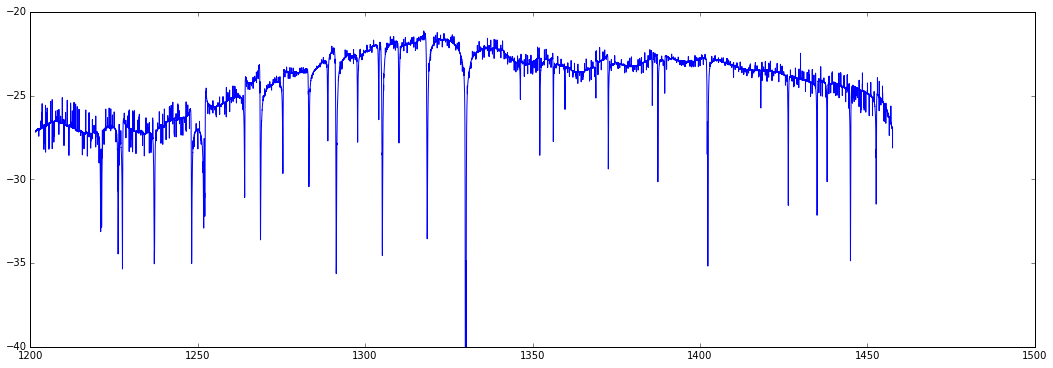

In [332]:
''' The plot of freq vs data'''
plot(freq,20*np.log10(np.abs(data)))# Base 10 to magnify the complex number
ylim(-40,-20)                       # It's the abs of complex no. that is read

In [333]:
'''Definitions by AstroTze'''
import numpy as np

'''This gives you two maximas (one to left, one to right) away from minima(Champ)'''
def give_me_2_maximas(champ,y,move,noise,tol):
    away = move + noise
    temp_champ = champ                           
    hl = 0                             
    hr = 0                             
    while y[temp_champ ] <= y[temp_champ - tol*away] and temp_champ !=0:            
        temp_champ = temp_champ - 1                        
        hl = hl +1                   
    temp_champ = champ                          
    while y[temp_champ] <= y[temp_champ + tol*away] and temp_champ != len(y)-tol*away:            
        temp_champ = temp_champ + 1                        
        hr = hr +1
    return hl,hr

'''Gives you two points above 2 Full Width Half Max, counting from Minima to Maxima'''
def give_me_2_half_maxes(champ,y,h_fwhm): 
    j = champ                    
    xl = 0                       
    xr = 0                       
    while y[j] < h_fwhm:         
        j = j-1                  
        xl = xl + 1               
    j = champ                    
    while y[j] < h_fwhm:         
        j = j+1                  
        xr = xr + 1               
    return xl,xr

'''This gives you the all important gamma'''
def give_me_gamma(x,champ,xl,xr):
    gam1 = abs(abs(x[champ - xl]) - abs(x[champ]))
    gam2 = abs(abs(x[champ + xr]) - abs(x[champ]))
    gamma=(gam1 + gam2)/2
    return gamma

'''Returns the difference between an ideal, and a measured y.Used for chi-square'''   
def residuals(p,y_ideal, x_ideal):  
    err = y_meas - neg_Lorentz(x_ideal,p)        # y_meas - y_ideal
    return err 

'''This returns the Lorentzian function'''
def neg_Lorentz(x, p):                           #returns the negative lorentzian 
    Numerator = p[2]                             #p[0] = Considered as 'x0': centre of x  
    Denominator = ((x - p[0])**2 + p[2])         #p[1] = (gamma*np.pi) 
    Co_eff = 1/p[1]                              #p[2] = gamma**2 
    Background = p[3]                            #p[3] =  Considered as 'y0': background
    return (-1 * Co_eff * (Numerator/Denominator)) + Background
 
'''This code returns will return the average gradient to the right side of the curve'''   
def right_gradient_average(x,y,center,move,away):
    dx = np. gradient(x[center + move : center + away])
    right_gradient = np.gradient(y[center + move: center + away],dx)
    right_gradient_ave = np.average(right_gradient)
    return right_gradient_ave 

'''This code returns will return the average gradient to the left side of the curve''' 
def left_gradient_average(x,y,center,move,away):
    dx = np. gradient(x[center - away : center - move])
    left_gradient = np.gradient(y[center - away : center - move],dx)
    left_gradient_ave = np.average(left_gradient)
    return left_gradient_ave
    
'''This returns ALL the local minimums'''
def Minima(x, y, move, noise,flat):                # move points before and after minimum
    locmins = []
    away = move + noise
    for center in range(away, len(y) - (away)):    # noiseth point after move is checked
        left_min = 0
        right_min = 0 
        for j in range(move):                                                 
            if y[center-j] <= -1* abs(y[center - (j+noise)] + y[center - (j+(noise-1))]) / 2 and y[center] <= y[center-1]:   
                left_min = left_min + 1   
            if y[center+j] <= -1* abs(y[center + (j+noise)] + y[center + (j+(noise-1))]) / 2 and y[center] <= y[center+1]:
                right_min = right_min + 1 
        
        right_gradient_ave = right_gradient_average(x,y,center,move,away)
        left_gradient_ave = left_gradient_average(x,y,center,move,away)
        
        if left_min + right_min == 2*move:
            if left_gradient_ave < 0 and right_gradient_ave > 0:
                if left_gradient_ave < -1*flat and right_gradient_ave > flat:
                    locmins.append([ x[center], y[center] ])
    return locmins                                  # Returns set of all local minimas

'''This removes any local minimums that are the same and next to each other '''
def remove_repeated(locmins):
    for i in range(1,len(locmins)):
        if locmins[i][1] == locmins[i-1][1]:        # The second index [1] is the y-axis!
            locmins[i][0]=0
            locmins[i][1]=0 
    while [0,0] in locmins: locmins.remove([0,0])
    return locmins

'''This code ranks the local minimums for you, according to indexes in y '''
def rank_the_locmins(locmins,y):
    for i in range(len(y)):                         # Sorts locmins into their position
        for j in range (len(locmins)):
            if y[i] == locmins[j][1]:
                if len(locmins[j])==2:              # Prevents picking up repeated points
                    locmins[j].append(i)
    return locmins

'''This will sort out the locmins and remove any minimas which are too close'''
def remove_close_by_mins(locmins,move,noise):
    for i in range(1,len( locmins)):
        after = locmins[i][2]
        before = locmins[i-1][2]
        diff = abs(after - before)
        away = move + noise
        if diff < away :
            y_after = locmins[i]
            y_before = locmins[i-1]
            if y_after < y_before :
                locmins[i-1] = [0,0,0]
            if y_after > y_before :
                locmins[i] = [0,0,0]
    while [0,0,0] in locmins: locmins.remove([0,0,0])
    return locmins


In [334]:
'''Test cell of actual data by AstroTze : These 4 parameters define the search for minimums'''
flat = 1.2                              # flat is the gradient of the points around centre
move = 5                                # move is the number of points around of centre
noise = 5                               # noise is how many points away from 'move'
tol = 1                                 # tolerance determine spread of lorentz function

length of data 32768
There are 36 resonators, and they occur at ...'
... these frequencies & data numbers
1 1220.9765625 		-33.1219951956
2 1221.25 		-32.8532786777
3 1226.171875 		-34.4539471071
4 1227.46875 		-34.2255308117
5 1236.9609375 		-34.9767043493
6 1248.1484375 		-35.0230008177
7 1251.75 		-32.9079550993
8 1252.0859375 		-32.1999891693
9 1263.9765625 		-31.0803250273
10 1268.703125 		-33.6111148132
11 1275.3984375 		-29.6476439313
12 1283.171875 		-30.4361533103
13 1288.8203125 		-27.6973588984
14 1291.328125 		-35.6302226431
15 1297.7265625 		-27.7788344157
16 1304.0390625 		-26.4336752332
17 1305.1015625 		-34.5468471503
18 1310.0625 		-27.8254459921
19 1318.4921875 		-33.5482191418
20 1346.328125 		-25.2203384846
21 1352.125 		-28.5604651254
22 1356.1640625 		-27.7355898259
23 1359.65625 		-25.8192480918
24 1368.8828125 		-25.1404558801
25 1372.59375 		-29.3762206551
26 1385.734375 		-25.5779921556
27 1387.3984375 		-30.1442885274
28 1389.4453125 		-24.8547588908
29 1402.

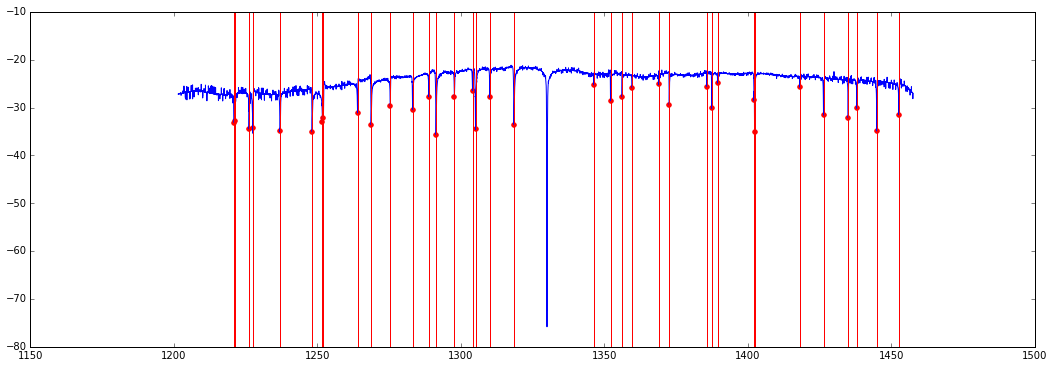

In [335]:
'''Test cell of actual data by AstroTze, This reads the local minimums'''
import scipy

a = freq
b = data
x = a
y = 20 * np.log10(np.abs(b))

locmins = Minima(x, y, move, noise,flat)                 
remove_repeated(locmins)                              
locmins = rank_the_locmins(locmins,y)   
locmins = remove_close_by_mins(locmins,move,noise)

print 'length of data',len(data)
print "There are",len(locmins),"resonators, and they occur at ...'"
print "... these frequencies & data numbers"
order_of_mins = []                       # order_of_mins is the list of all resonators
for i in range(len(locmins)):
    print i+1, locmins[i][0],'\t','\t', locmins [i][1]
    order_of_mins.append([i+1, locmins[i][0], locmins [i][1]])
    
plot(x, y)
#scatter(x, y, alpha = 0.7)
ylim=(-40, -20)
ax = gca()                                              
for i in range(len(locmins)):
    ax.axvline(locmins[i][0], color = 'red')         
    scatter (locmins[i][0], locmins[i][1], color = 'red') 


In [336]:
''' m & n refines the search to look lorentz-fitted function of individual resonators'''
m = 0                       # Set to 2370 for first two peaks // Set to 0 for min
n = 32768                   # Set to 2610 for first two peaks // Set to 32768 for max 

And these are the chisquare of those points
1 Chi_squared is 3.20781440324
2 Chi_squared is 1.97168993574
3 Chi_squared is 0.14749572427
4 Chi_squared is 65.3081690897
5 Chi_squared is 11.1658294688
6 Chi_squared is 77.3980218632
7 Chi_squared is 16.5930376968
8 Chi_squared is 9.11888516869
9 Chi_squared is 60.4072291613
10 Chi_squared is 173.512355778
11 Chi_squared is 37.326653699
12 Chi_squared is 21.5959235042
13 Chi_squared is 0.586312173621
14 Chi_squared is 178.122720952
15 Chi_squared is 0.475124614128
16 Chi_squared is 2.07146184792
17 Chi_squared is 62.4713465476
18 Chi_squared is 8.09197532611
19 Chi_squared is 96.6829821473
20 Chi_squared is 1.98255774937
21 Chi_squared is 13.3925015828
22 Chi_squared is 6.17114624302
23 Chi_squared is 0.821559112864
24 Chi_squared is 1.69045310215
25 Chi_squared is 23.8088802121
26 Chi_squared is 0.221762536531
27 Chi_squared is 17.799291693
28 Chi_squared is 1.92953767497
29 Chi_squared is 0.364718901825
30 Chi_squared is 5.3092631849
31 

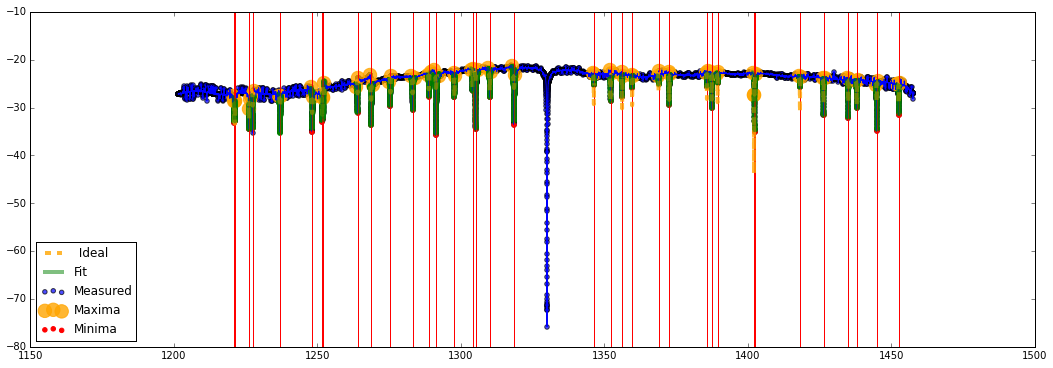

In [337]:
''' This block of code finds you the lorentz fitted function, and plots it all for you '''

a = freq[m:n]
b = data[m:n]
x = a
y = 20 * np.log10(np.abs(b))

locmins = Minima(x, y, move, noise,flat)                 
remove_repeated(locmins)                              
locmins = rank_the_locmins(locmins,y)   
locmins = remove_close_by_mins(locmins,move,noise)

index = 0               # If you "zoom in" by toggling m & n, index just keeps track
                        # of which of the resonators you are looking at
for j in range(len(order_of_mins)):
    if locmins[0][0]==order_of_mins[j][1]:
        index = order_of_mins[j][0]
        break
        
plot(x, y)
scatter(x, y, alpha = 0.7, label = "Measured")
ylim=(-40, -20)
ax = gca()                                              
for i in range(len(locmins)):
    ax.axvline(locmins[i][0], color = 'red')         
    scatter (locmins[i][0], locmins[i][1], color = 'red')    

    
print "And these are the chisquare of those points" 
count_chi=0
count_chi_less_than_1=0

for j in range(len(locmins)):
    champ = locmins[j][2]
            
    hl,hr =  give_me_2_maximas(champ,y,move,noise,tol)# hl, hr : height to left, right              
    fwfm = abs (x[champ + hr] - x[champ - hl])        # fwfm   : full width full max
    h_fwfm = abs (y[champ + hr] - y[champ])           # h_fwfm : height fwfm    
    h_fwhm = (abs(y[champ]) - 0.5 * h_fwfm) * -1      # fwhm   : full width half max             
    xl, xr = give_me_2_half_maxes(champ,y,h_fwhm)     # h_fwhm : height fwhm        
    gamma = give_me_gamma(x,champ,xl,xr)              # xl,xr : half max to left,right        
                                                                  
    p=[0.0, 0.0, 0.0, 0.0]                            
    p[0] = x[champ]                                             
    p[1] = (gamma * np.pi)
    p[2] = gamma**2
    p[3] = y[champ + hr]
    #print j+1,p, "The original parameters"  
    
    x_ideal = np.linspace(x[champ - hl], x[champ + hr], hl+hr)# x_fit = x_ideal = x_meas
    y_ideal = neg_Lorentz(x_ideal,p)
    y_meas = y[champ - hl : champ + hr]
    x_meas = x_ideal
    
    scatter(x[champ - hl], y[champ - hl], color = 'orange', s=180 , alpha = 0.8 )
    scatter(x[champ + hr], y[champ + hr], color = 'orange', s=180 , alpha = 0.8)
    plot(x_ideal, y_ideal, color = 'orange', linewidth = 4, linestyle = '--',alpha = 0.8)                                       
    
    from scipy.optimize import leastsq
    plsq = leastsq(residuals, p, args=(y_meas,x_meas))      
    #print j+1,(plsq[0]), "The parameters for leastsq"   
    
    x_fit = x_ideal                                                 
    y_fit = neg_Lorentz(x_ideal,plsq[0])
    plot(x_fit, y_fit, color = 'green', linewidth = 4 , alpha = 0.5 )
    scatter(x_fit, y_fit, color = 'green', alpha = 0.5 )
    
    chi_squared=0
    for item in range(len(y_meas)):
        element = (y_meas[item]-y_fit[item])**2
        chi_squared = chi_squared + element
        
    print j + index, "Chi_squared is", chi_squared
    if chi_squared > 100:
        count_chi = count_chi +1
    if chi_squared < 1:
        count_chi_less_than_1=count_chi_less_than_1 +1
        
print "The number of fits with Chi_square more than 100 is", count_chi 
print "The number of fits with Chi_square less than 1 is", count_chi_less_than_1 

#savefig('Resonant_Plot.pdf')
###############################################Everything below is just for labelling !!!
scatter(x[champ - hl], y[champ - hl], color = 'orange', s=180 , alpha = 0.8, label = "Maxima" )    
scatter (locmins[j][0], locmins[j][1], color = 'red', label = "Minima")    
plot(x_ideal, y_ideal, color = 'orange', linewidth = 4, linestyle = '--', alpha = 0.8 , label = " Ideal" )
plot(x_fit, y_fit, color = 'green', linewidth = 4 , alpha = 0.5 , label = "Fit" )
legend(loc=3)